In [1]:
import torch
from torch import nn
class SoftmaxWeight(nn.Module):
    def __init__(self, K, p, hidden_dimensions =[]):
        super().__init__()
        self.K = K
        self.p = p
        self.network_dimensions = [self.p] + hidden_dimensions + [self.K]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1),nn.Tanh(),])
        network.pop()
        self.f = nn.Sequential(*network)

    def log_prob(self, z):
        unormalized_log_w = self.f.forward(z)
        return unormalized_log_w - torch.logsumexp(unormalized_log_w, dim=-1, keepdim=True)

In [2]:
###MNIST###
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
train_labels = mnist_trainset.targets[:10000]
test_labels = mnist_testset.targets[:5000]
validation_labels = mnist_testset.targets[5000:]

extracted_train = mnist_trainset.data.flatten(start_dim=1).float()[:10000]
train_samples = (extracted_train + torch.rand(extracted_train.shape))/256
extracted_test = mnist_testset.data.flatten(start_dim=1).float()[:5000]
test_samples = (extracted_test + torch.rand(extracted_test.shape))/256
extracted_validation = mnist_testset.data.flatten(start_dim=1).float()[5000:]
validation_samples = (extracted_validation + torch.rand(extracted_validation.shape))/256

In [3]:
from tqdm import tqdm

In [8]:
w = SoftmaxWeight(10,784,[128,128])
optim = torch.optim.Adam(w.parameters(), lr = 5e-4)
list_accuracy_train = []
list_accuracy_loss = []
list_accuracy_validation = []
list_loss_train = []
list_loss_test = []
list_loss_validation = []
device = torch.device('cuda')
train_samples = train_samples.to(device)
train_labels = train_labels.to(device)
test_samples = test_samples.to(device)
test_labels = test_labels.to(device)
validation_samples = validation_samples.to(device)
validation_labels = validation_labels.to(device)
counts = torch.unique(train_labels, return_counts = True)[1]
test_samples = test_samples.to(device)
test_labels = test_labels.to(device)
w.to(device)
for t in tqdm(range(2000)):
    optim.zero_grad()
    loss_train = -torch.mean((w.log_prob(train_samples)*counts)[range(train_samples.shape[0]),train_labels])
    with torch.no_grad():
        accuracy_train = torch.mean((torch.max(w.log_prob(train_samples), dim = 1)[1] == train_labels).float())
        loss_test = -torch.mean((w.log_prob(test_samples)*counts)[range(test_samples.shape[0]),test_labels])
        accuracy_test = torch.mean((torch.max(w.log_prob(test_samples), dim = 1)[1] == test_labels).float())
        loss_validation = -torch.mean((w.log_prob(validation_samples)*counts)[range(validation_samples.shape[0]),validation_labels])
        accuracy_validation = torch.mean((torch.max(w.log_prob(validation_samples), dim = 1)[1] == validation_labels).float())
    loss_train.backward()
    list_accuracy_train.append(accuracy_train.cpu())
    list_accuracy_loss.append(accuracy_test.cpu())
    list_accuracy_validation.append(accuracy_validation.cpu())
    list_loss_train.append(loss_train.cpu().detach())
    list_loss_test.append(loss_test.cpu())
    list_loss_validation.append(loss_validation.cpu())
    optim.step()
w.cpu()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 136.51it/s]


SoftmaxWeight(
  (f): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

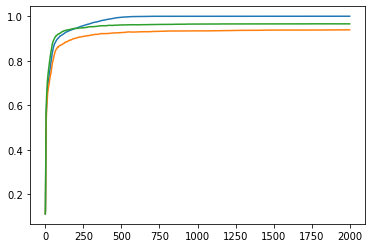

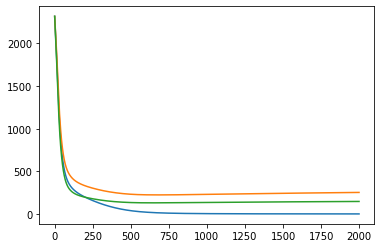

In [10]:
plt.plot(list_accuracy_train)
plt.plot(list_accuracy_loss)
plt.plot(list_accuracy_validation)
plt.show()
plt.plot(list_loss_train)
plt.plot(list_loss_test)
plt.plot(list_loss_validation)
plt.show()

In [ ]:
sample = test_samples[0].cpu()
plt.imshow(sample.reshape(28,28))
print(torch.exp(w.log_prob(sample)))

In [ ]:
list_accuracy_gibbs = []
for i in tqdm(range(10)):
    fake_labels= torch.distributions.Categorical(torch.exp(w.to(device).log_prob(test_samples.to(device)))).sample()
    samples = torch.cat([train_samples.to(device), test_samples.to(device)], dim = 0)
    w = SoftmaxWeight(10,784,[128,128]).to(device)
    optim = torch.optim.Adam(w.parameters(), lr = 5e-4)
    weights = torch.distributions.Dirichlet(torch.ones(samples.shape[0]).to(device)).sample()
    for t in range(2000):
        labels = torch.cat([train_labels.to(device), fake_labels], dim =0)
        optim.zero_grad()
        counts = torch.unique(labels, return_counts = True)[1] 
        loss = -torch.sum((w.log_prob(samples))[range(labels.shape[0]),labels]*weights)
        accuracy = torch.mean((torch.max(w.log_prob(test_samples), dim = 1)[1] == test_labels).float())
        loss.backward()
        optim.step()
        list_accuracy_gibbs.append(accuracy)

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(torch.stack(list_accuracy).cpu().numpy(), label = 'Standard')
plt.plot(torch.stack(list_accuracy_gibbs).cpu().numpy(), label = 'Gibbs')
plt.legend()
plt.show()

In [ ]:
print(torch.max(torch.stack(list_accuracy)))
print(torch.max(torch.stack(list_accuracy_gibbs)))

In [ ]:
w.cpu()
accuracy = torch.mean((torch.max(w.log_prob(validation_samples), dim = 1)[1] == validation_labels).float())
print(accuracy)